C:\Users\vsrng\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ (None, 300, 64)        │         1,344 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_2 (Bidirectional) │ (None, 128)            │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 76,103 (297.28 KB)

 Trainable params: 76,103 (297.28 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 433s 281ms/step - loss: 0.0267 - mae: 0.1162 - val_loss: 0.0021 - val_mae: 0.0328
Epoch 2/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 396s 264ms/step - loss: 0.0023 - mae: 0.0360 - val_loss: 7.8008e-04 - val_mae: 0.0203
Epoch 3/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 388s 259ms/step - loss: 0.0013 - mae: 0.0278 - val_loss: 0.0012 - val_mae: 0.0244
Epoch 4/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 407s 271ms/step - loss: 0.0012 - mae: 0.0261 - val_loss: 7.4736e-04 - val_mae: 0.0214
Epoch 5/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 298s 198ms/step - loss: 0.0010 - mae: 0.0241 - val_loss: 6.5157e-04 - val_mae: 0.0193
Epoch 6/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 281s 187ms/step - loss: 9.1525e-04 - mae: 0.0228 - val_loss: 7.4010e-04 - val_mae: 0.0207
Epoch 7/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 283s 189ms/step - loss: 8.6931e-04 - mae: 0.0223 - val_loss: 6.0758e-04 - val_mae: 0.0189
Epoch 8/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 299s 199ms/step - loss: 7.7217e-04 - mae: 0.0208 - val_loss: 5

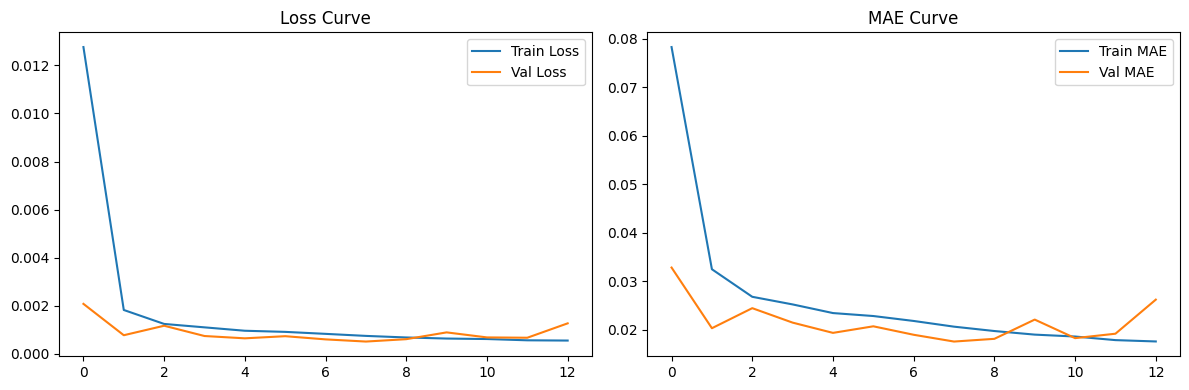

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GlobalMaxPooling1D
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def read_rename(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    df = df.rename(columns={
        'ID_Proteína': 'protein_id',
        'Sequência': 'sequence',
        'Massa_Molecular': 'molecular_weight',
        'Ponto_Isoelétrico': 'isoelectric_point',
        'Hidrofobicidade': 'hydrophobicity',
        'Carga_Total': 'total_charge',
        'Proporção_Polar': 'polar_ratio',
        'Proporção_Apolar': 'nonpolar_ratio',
        'Comprimento_Sequência': 'sequence_length',
        'Classe': 'class'
    })

    return df
# 1. Load data
df = read_rename('proteinas_20000_enriquecido.csv')

# 2. Mapping karakter ke angka
all_chars = set("".join(df['sequence'].values))
char_to_index = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
vocab_size = len(char_to_index) + 1

# 3. Encode sequence
encoded_sequences = [[char_to_index[char] for char in seq] for seq in df['sequence']]
max_length = max(len(seq) for seq in encoded_sequences)
X_all = pad_sequences(encoded_sequences, maxlen=max_length, padding='post')

# 4. Target variabel
y_all = df[['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'total_charge', 'polar_ratio','nonpolar_ratio','sequence_length']].values

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# 6. Scaling target
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# 7. Buat model LSTM
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    Bidirectional(LSTM(64, return_sequences=False)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(7)  
])

model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.build(input_shape=(None, max_length))  
model.summary()

# 8. Callback EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 9. Train model
history = model.fit(
    X_train, y_train_scaled,
    epochs=30,
    batch_size=32,
    validation_data=(X_test, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

# 10. Prediksi
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# 11. Tampilkan 5 hasil prediksi pertama
print(pd.DataFrame(y_pred[:5], columns=['mw', 'pI', 'hydro', 'charge', 'polar', 'nonpolar', 'seq_len']))

# 12. Visualisasi
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title("MAE Curve")

plt.tight_layout()
plt.show()


In [10]:
df = read_rename('proteinas_20000_enriquecido.csv')

In [11]:
X_all = df.drop('class', axis=1)  # Drop kolom 'target' untuk mendapatkan fitur
y_all = df['class']    

In [12]:
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

In [13]:
X_test

,protein_id,sequence,molecular_weight,isoelectric_point,hydrophobicity,total_charge,polar_ratio,nonpolar_ratio,sequence_length
12628,P12629,ALVFQYRYDLRNTQKHIHVWCYVIGAMQHRIVLHYSPKNPYMVKGQ...,25607.7191,9.364500,0.173709,24,0.197183,0.417840,213
37730,P37731,AGEHGVFIIKGSRQRCWDKFREKWELSGKTKVLFARPKDHPSMLDR...,16861.8165,7.258362,0.094203,8,0.181159,0.340580,138
39991,P39992,TNYKKMDTYKAWFCGQIWPHEPSECKRTCQMDIFFTKNILNGGTGA...,15163.1604,6.735841,0.172000,3,0.248000,0.432000,125
8525,P08526,HPNQYTRLKFSHRIHKQLPMAQDCVLRVELIVPYWDSAHVCEHQEW...,15108.8043,5.745422,0.115079,2,0.230159,0.365079,126
8279,P08280,WHPYLHCLFLVNGCLAEHLIAFVWRRTPLTETHPTQMQDFINLSLK...,16762.7661,9.508845,0.199301,15,0.181818,0.454545,143
...,...,...,...,...,...,...,...,...,...
49914,P49915,GPPWDYTSAHYEHPCMVQHANHGIAEFWQVGCCSVMLVPHIYITWK...,9959.1165,5.650046,0.117647,2,0.188235,0.352941,85
34428,P34429,GGVQMAIEFGRTMQEQSFEADSTQAHPSHFAMGGGKNGQFTQSGGY...,21679.5298,5.965730,0.133690,3,0.219251,0.379679,187
45810,P45811,SMSQAYLFCNDALNRTIMGRMFEGAKCPDMNQRMHMITYFAPMEPV...,28764.1247,6.534745,0.142857,8,0.171429,0.391837,245
30357,P30358,ASDPDVEFPILTEVTYTIYFWSLDSCWCLMKHNVSGPLTCNIPPIQ...,23107.1354,5.818687,0.128205,3,0.215385,0.379487,195


In [17]:
import pickle
import json
import os

# Buat folder untuk simpan model & preprocessing (jika belum ada)
os.makedirs('model', exist_ok=True)

# Simpan model
model.save('model/lstm_model.keras')

# Simpan scaler
with open('model/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Simpan char_to_index
with open('model/char_to_index.pkl', 'wb') as f:
    pickle.dump(char_to_index, f)

# Simpan max_length
with open('model/config.json', 'w') as f:
    json.dump({"max_length": max_length}, f)

print("✅ Model, scaler, char_to_index, dan config berhasil disimpan.")


✅ Model, scaler, char_to_index, dan config berhasil disimpan.


In [16]:
print("Vocab size:", vocab_size)
print("char_to_index keys:", list(char_to_index.keys())[:21])


Vocab size: 21
char_to_index keys: ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']


In [8]:
print(y_test[:5])

[[2.56077191e+04 9.36450024e+00 1.73708920e-01 2.40000000e+01
  1.97183099e-01 4.17840376e-01 2.13000000e+02]
 [1.68618165e+04 7.25836201e+00 9.42028986e-02 8.00000000e+00
  1.81159420e-01 3.40579710e-01 1.38000000e+02]
 [1.51631604e+04 6.73584118e+00 1.72000000e-01 3.00000000e+00
  2.48000000e-01 4.32000000e-01 1.25000000e+02]
 [1.51088043e+04 5.74542179e+00 1.15079365e-01 2.00000000e+00
  2.30158730e-01 3.65079365e-01 1.26000000e+02]
 [1.67627661e+04 9.50884495e+00 1.99300699e-01 1.50000000e+01
  1.81818182e-01 4.54545455e-01 1.43000000e+02]]


In [9]:
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    mask = y_true != 0
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

mape = mean_absolute_percentage_error(y_test, y_pred)
print(f"MAPE: {mape:.2f}%")

MAPE: 5.54%


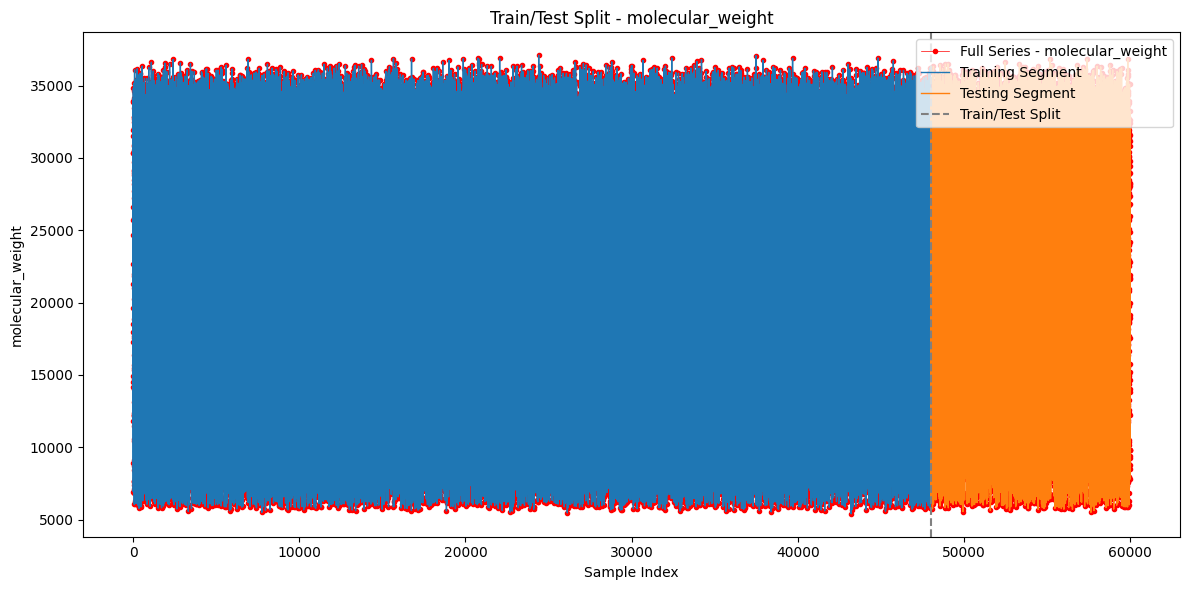

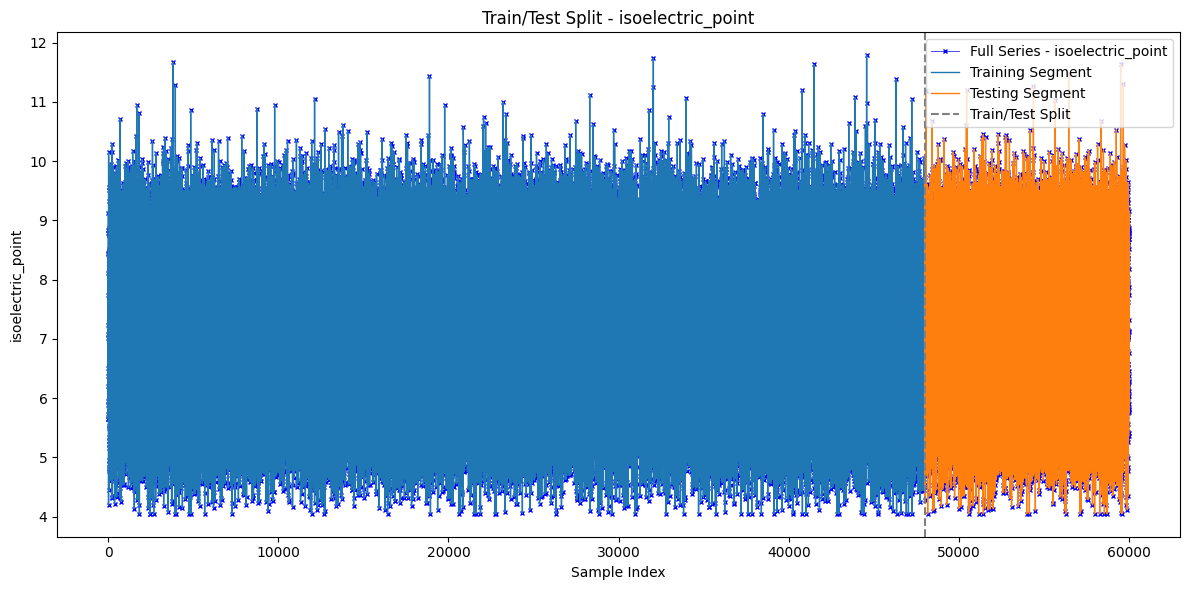

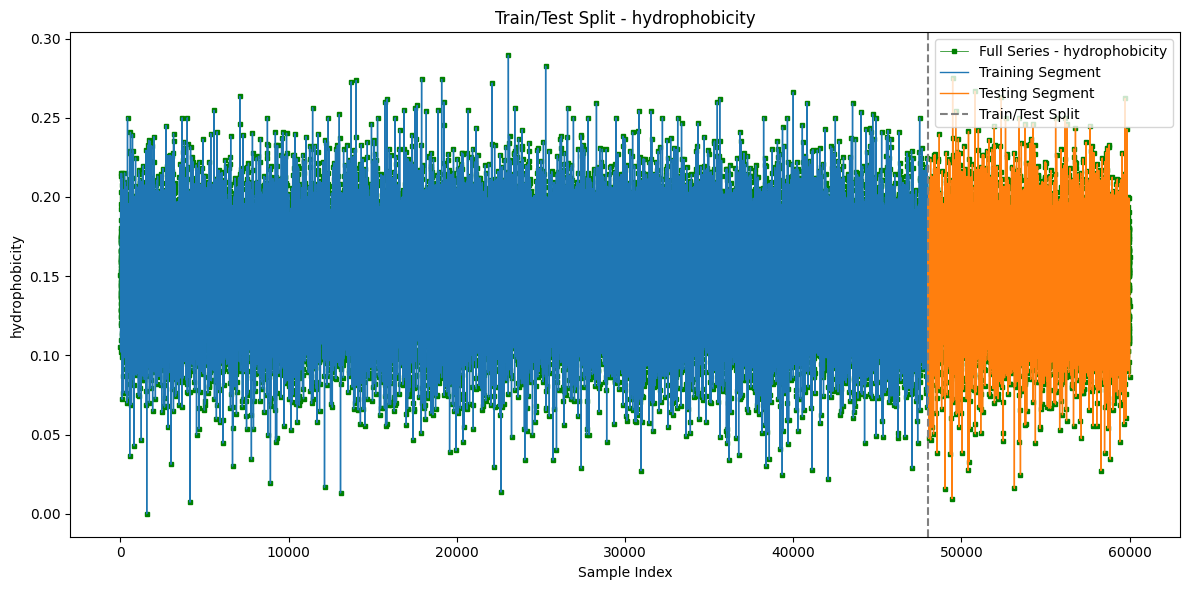

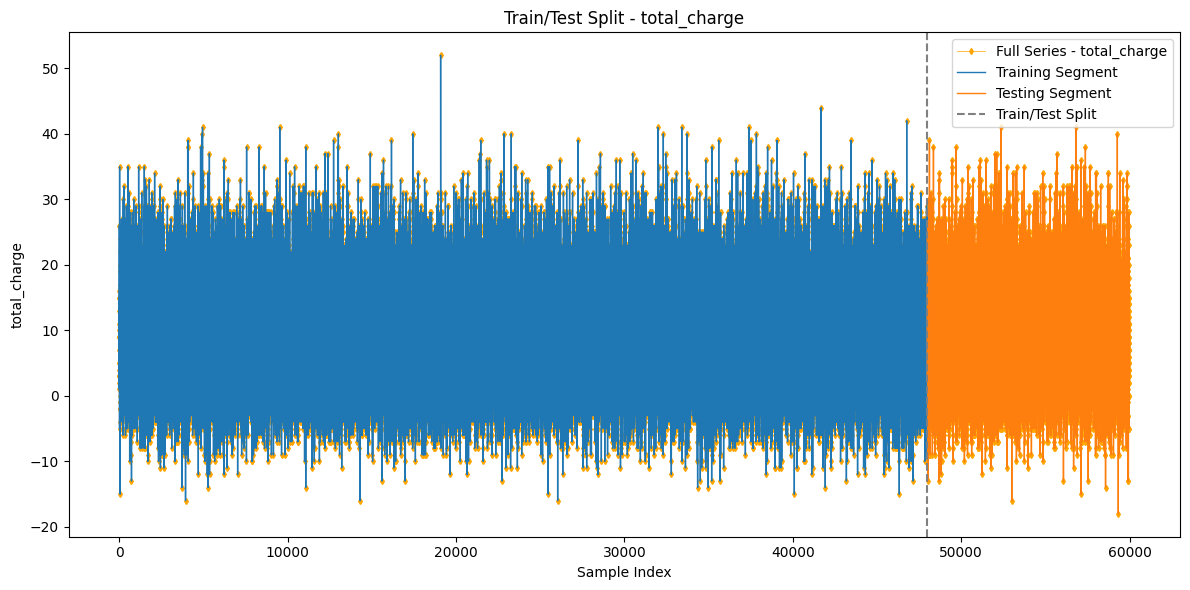

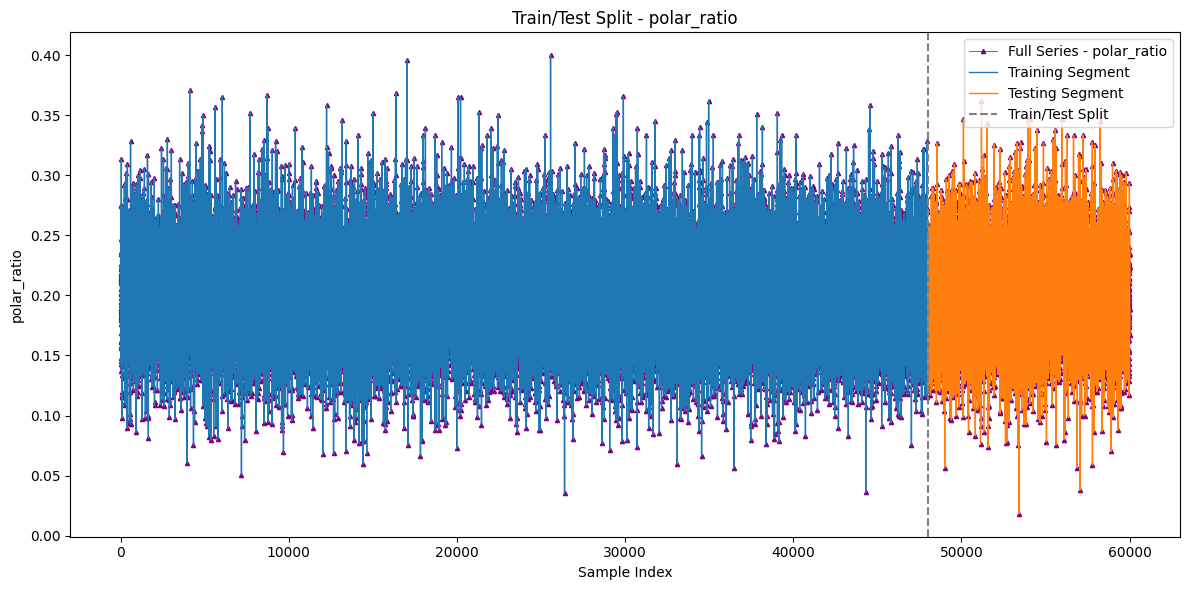

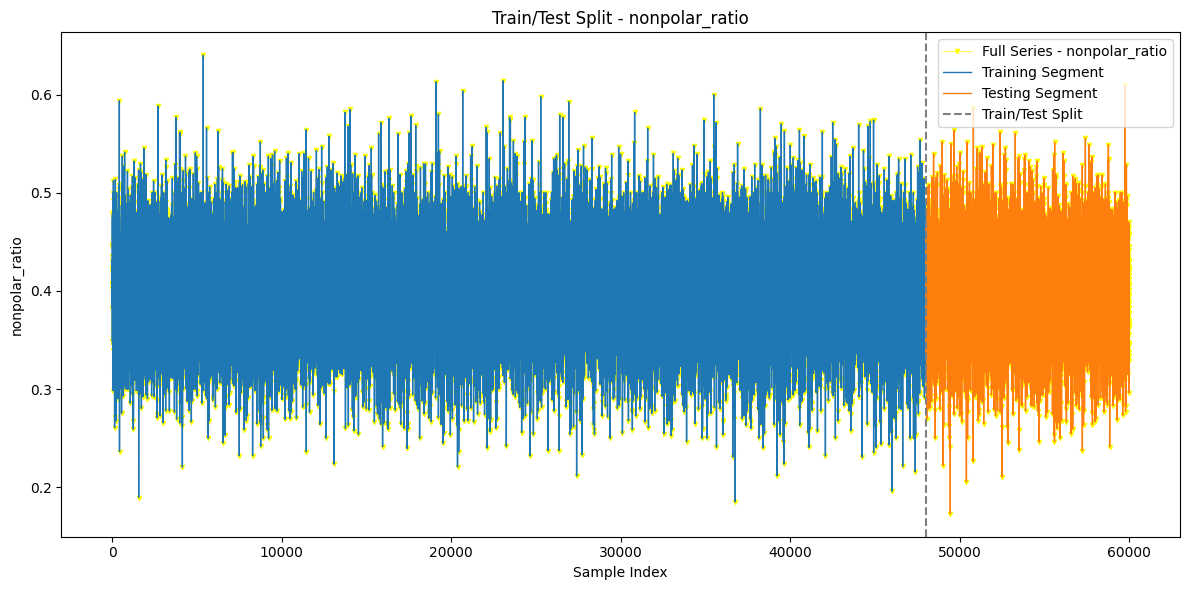

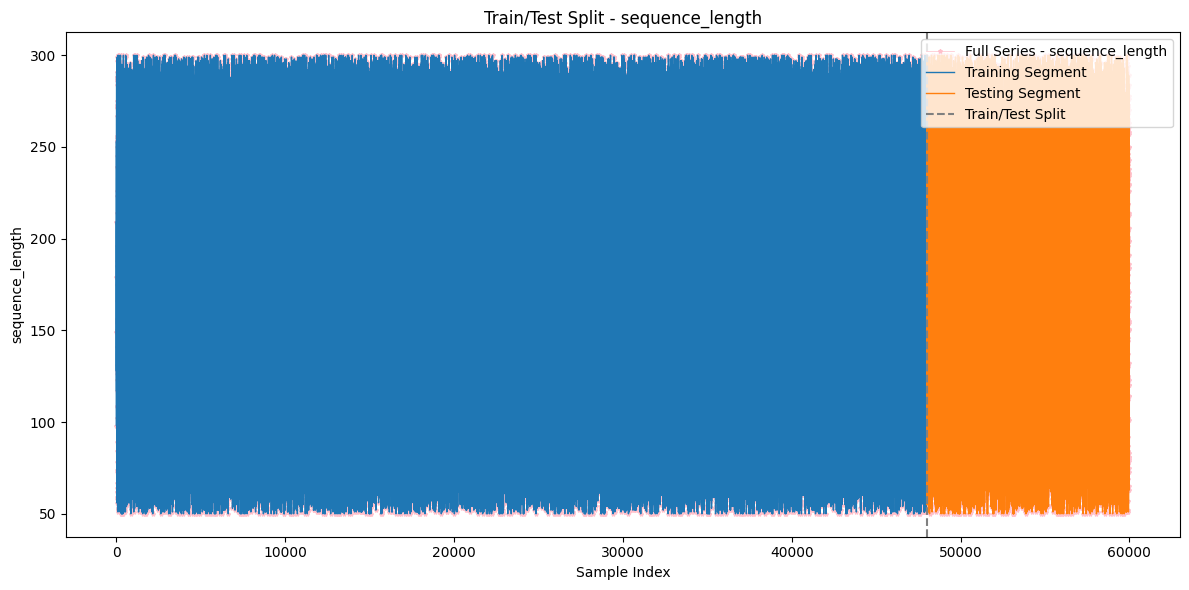

In [84]:
import matplotlib.pyplot as plt
import numpy as np

# Asumsikan y_full adalah numpy array (N x 7)
time = np.arange(len(y))
split_idx = int(0.8 * len(y))  
window_size = 0

train_end_time = split_idx + window_size
test_start_time = train_end_time

feature_names = ['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'total_charge',
                 'polar_ratio','nonpolar_ratio','sequence_length']
colors = ['red', 'blue', 'green', 'orange', 'purple', 'yellow', 'pink']
markers = ['o', 'x', 's', 'd', '^', 'v', '*']

def plot_feature(time, series, feature_name, color, marker):
    plt.figure(figsize=(12, 6))
    plt.plot(time, series, linestyle='-', linewidth=0.5, marker=marker, markersize=3,
             color=color, label=f'Full Series - {feature_name}')
    
    plt.plot(time[window_size:train_end_time],
             series[window_size:train_end_time], color='C0', lw=1,
             label='Training Segment')
    
    plt.plot(time[test_start_time:], series[test_start_time:], color='C1', lw=1,
             label='Testing Segment')
    
    plt.axvline(x=train_end_time, color='gray', linestyle='--', label='Train/Test Split')
    plt.title(f"Train/Test Split - {feature_name}")
    plt.xlabel("Sample Index")
    plt.ylabel(f"{feature_name}")
    plt.legend(loc='upper right')
    plt.tight_layout()
    plt.show()

for i, (name, color, marker) in enumerate(zip(feature_names, colors, markers)):
    plot_feature(time, y_full[:, i], name, color, marker)


In [61]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
def read_rename(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)

    df = df.rename(columns={
        'ID_Proteína': 'protein_id',
        'Sequência': 'sequence',
        'Massa_Molecular': 'molecular_weight',
        'Ponto_Isoelétrico': 'isoelectric_point',
        'Hidrofobicidade': 'hydrophobicity',
        'Carga_Total': 'total_charge',
        'Proporção_Polar': 'polar_ratio',
        'Proporção_Apolar': 'nonpolar_ratio',
        'Comprimento_Sequência': 'sequence_length',
        'Classe': 'class'
    })

    return df
df1= read_rename('proteinas_20000_enriquecido.csv')

In [62]:
df1["class"].value_counts()

class
Outras        12216
Estrutural    11991
Transporte    11989
Enzima        11954
Receptora     11850
Name: count, dtype: int64

{'molecular_weight': ['sequence_length'], 'isoelectric_point': ['total_charge'], 'hydrophobicity': ['nonpolar_ratio'], 'total_charge': ['isoelectric_point'], 'polar_ratio': [], 'nonpolar_ratio': ['hydrophobicity'], 'sequence_length': ['molecular_weight']}


{'molecular_weight': [], 'isoelectric_point': [], 'hydrophobicity': [], 'total_charge': [], 'polar_ratio': [], 'nonpolar_ratio': [], 'sequence_length': []}


<Axes: >

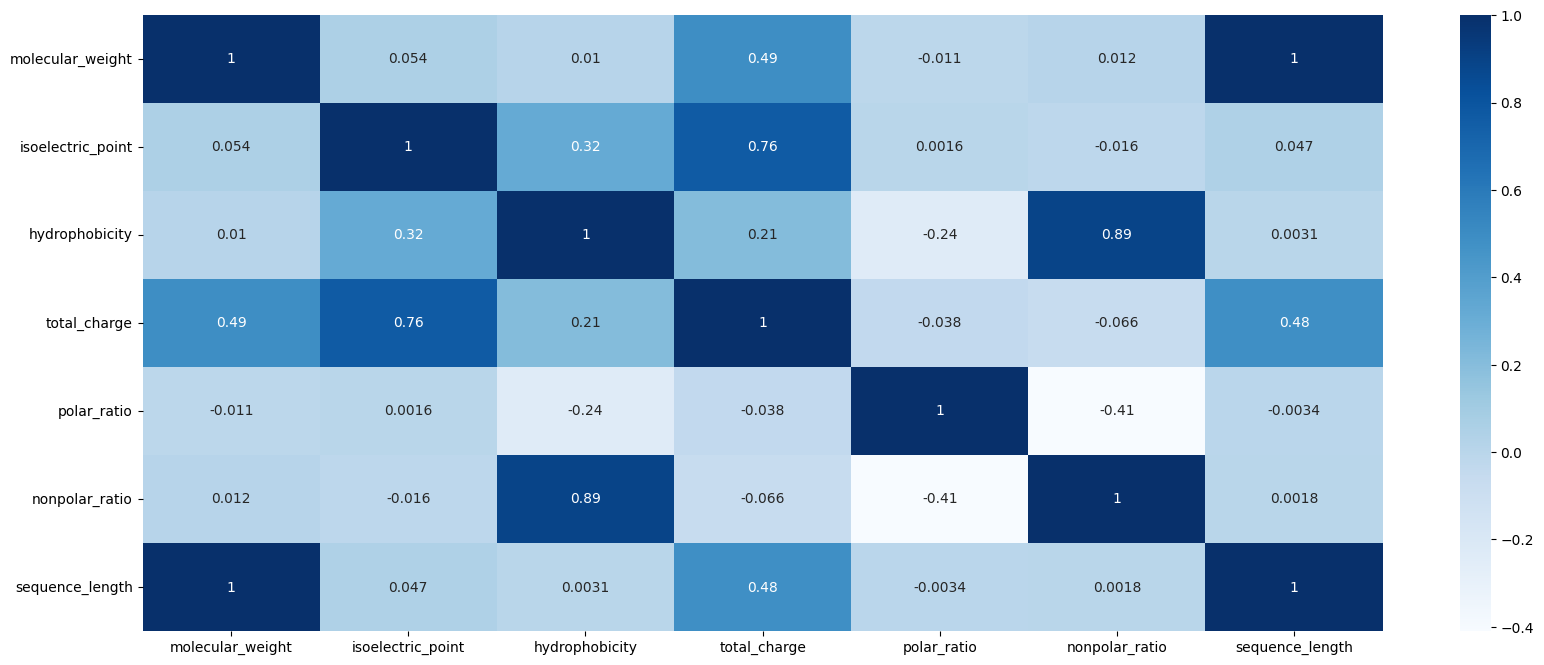

In [55]:
import seaborn as sns
corr = df1.select_dtypes(include = ["int64","float64"]).corr()
plt.figure(figsize=(20,8))
var = corr.columns
n = len(var)
pos = dict()
neg = dict()
for i in var:
    pos[i] = list()
    neg[i] = list()

for i in var:
    for j in range(n):
        if i == var[j]: continue
        if corr[i].iloc[j] > 0.7:
            pos[i].append(var[j])
        if corr[i].iloc[j] < -0.7:
            neg[i].append(var[j])

print(pos)
print("\n")
print(neg)
            
sns.heatmap(corr, cmap="Blues",annot=True)

In [63]:
from sklearn.preprocessing import LabelEncoder
train=df1
label_encoder = LabelEncoder()
train['class']=label_encoder.fit_transform(train['class'])

In [64]:
from sklearn.model_selection import train_test_split

X = train.drop(columns=['class'])
y = train['class']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y
)

In [66]:
import pandas as pd

def count_amino_acids(seq, aa_list):
    return sum(seq.count(aa) for aa in aa_list)

def interactions(X_train: pd.DataFrame) -> pd.DataFrame:
    def extract_features(row):
        seq = row['sequence']
        seq_len = len(seq)
        first_30 = seq[:30]

        # Fitur frekuensi berdasarkan kelas
        f_enzyme = count_amino_acids(seq, ['S', 'H', 'C', 'D', 'E', 'K']) / seq_len
        f_structural = count_amino_acids(seq, ['G', 'P', 'A', 'L', 'V', 'I']) / seq_len
        f_transport = count_amino_acids(seq, ['Y', 'R', 'H', 'D', 'E']) / seq_len
        f_receptor = count_amino_acids(seq, ['Y', 'S', 'T', 'R', 'H']) / seq_len
        f_outros = count_amino_acids(seq, ['Q', 'N', 'M', 'F', 'W']) / seq_len

        # Enzyme Hotspot Index (motif sederhana)
        enzyme_motif_count = seq.count('HDS') + seq.count('CHD')

        # Hydrophobicity segment profile (polar/nonpolar)
        hydrophobic = count_amino_acids(seq, ['A', 'V', 'L', 'I', 'M', 'F', 'W']) / seq_len
        polar = count_amino_acids(seq, ['D', 'E', 'K', 'R', 'S', 'T', 'H']) / seq_len
        # PTM Potential
        has_phospho_site = any(aa in seq for aa in ['Y', 'S', 'T'])
        has_glyco_site = 'N' in seq

        # Signal peptide proxy
        signal_peptide_score = count_amino_acids(first_30, ['M', 'K', 'R', 'L']) / min(30, seq_len)

        # Dominant class
        freqs = {
            'enzyme': f_enzyme,
            'structural': f_structural,
            'transport': f_transport,
            'receptor': f_receptor,
            'outros': f_outros
        }
        dominant_class = max(freqs, key=freqs.get)

        return pd.Series({
            # 'freq_enzyme': f_enzyme,
            # 'freq_structural': f_structural,
            # 'freq_transport': f_transport,
            # 'freq_receptor': f_receptor,
            # 'freq_outros': f_outros,
            'enzyme_motif_count': enzyme_motif_count,
            'hydrophobic_ratio': hydrophobic,
            'polarRation':polar,
            'has_phospho_site': has_phospho_site,
            'has_glyco_site': has_glyco_site,
            'signal_peptide_score': signal_peptide_score,
            'dominant_class': dominant_class
        })

    # Apply feature extraction row-wise
    features_df = X_train.apply(extract_features, axis=1)
    return pd.concat([X_train, features_df], axis=1)

def apply_feature_engineering(X: pd.DataFrame) -> pd.DataFrame:
    X = interactions(X)
    return X


In [67]:
X_train=apply_feature_engineering(X_train)
X_test=apply_feature_engineering(X_test)

In [68]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   protein_id         60000 non-null  object 
 1   sequence           60000 non-null  object 
 2   molecular_weight   60000 non-null  float64
 3   isoelectric_point  60000 non-null  float64
 4   hydrophobicity     60000 non-null  float64
 5   total_charge       60000 non-null  int64  
 6   polar_ratio        60000 non-null  float64
 7   nonpolar_ratio     60000 non-null  float64
 8   sequence_length    60000 non-null  int64  
 9   class              60000 non-null  int32  
dtypes: float64(5), int32(1), int64(2), object(2)
memory usage: 4.3+ MB


In [70]:
X_train = X_train.drop(columns=["protein_id","sequence","total_charge","hydrophobicity","molecular_weight","dominant_class","polar_ratio"])
X_test = X_test.drop(columns=["protein_id","sequence","total_charge","hydrophobicity","molecular_weight",'dominant_class',"polar_ratio"])

In [71]:
bool_cols = ['has_phospho_site', 'has_glyco_site']
X_train[bool_cols] = X_train[bool_cols].astype(int)
X_test[bool_cols] = X_test[bool_cols].astype(int)


In [83]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report

# Inisialisasi model XGBoost
xgb_model = xgb.XGBClassifier(random_state=42)

# Latih model pada data pelatihan
xgb_model.fit(X_train, y_train)

# Lakukan prediksi pada data pengujian
y_pred = xgb_model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model XGBoost: {accuracy:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))

Akurasi Model XGBoost: 0.2039

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.21      0.17      0.18      2391
           1       0.21      0.18      0.20      2398
           2       0.21      0.22      0.22      2443
           3       0.20      0.18      0.19      2370
           4       0.19      0.26      0.22      2398

    accuracy                           0.20     12000
   macro avg       0.20      0.20      0.20     12000
weighted avg       0.20      0.20      0.20     12000



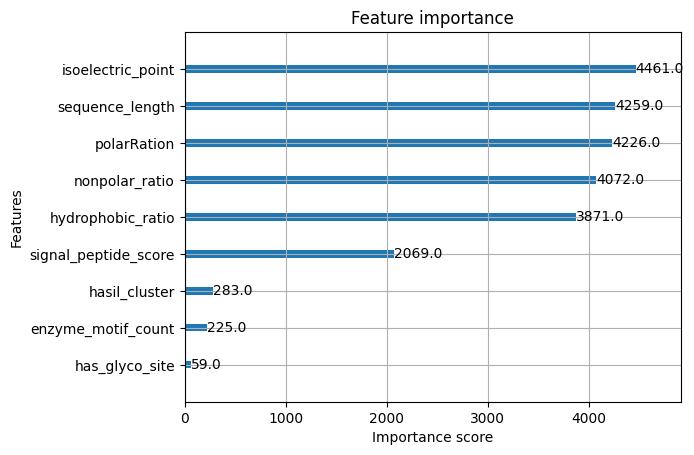

In [84]:
from xgboost import plot_importance
import matplotlib.pyplot as plt

# Setelah model XGBoost dilatih
plot_importance(xgb_model)
plt.show()


In [85]:
xgb_params = {
    'gamma': 0.38,
    'lambda': 2,
    'alpha': 0.7,
    'learning_rate': 0.0154460689966283828,
    'max_depth': 5,
    # 'min_child_weight': 9,
    # 'subsample': 0.8,
    # 'colsample_bytree': 0.7,
    'objective': "multi:softprob",
    'use_label_encoder': False,
    'verbosity': 0
}

# ============================
# 🔹 Inisialisasi & Training Model
# ============================
model = xgb.XGBClassifier(
    n_estimators=250,
    **xgb_params,
    eval_metric="auc",
    verbose=50,
    use_best_model=True,
    random_seed=42
)

# Train the model
model.fit(X_train, y_train)

# Lakukan prediksi pada data pengujian
y_pred = model.predict(X_test)

# Evaluasi model
accuracy = accuracy_score(y_test, y_pred)
print(f"Akurasi Model XGBoost: {accuracy:.4f}")

print("\nLaporan Klasifikasi:")
print(classification_report(y_test, y_pred))

Akurasi Model XGBoost: 0.2097

Laporan Klasifikasi:
              precision    recall  f1-score   support

           0       0.20      0.19      0.19      2391
           1       0.21      0.20      0.20      2398
           2       0.22      0.37      0.28      2443
           3       0.20      0.11      0.15      2370
           4       0.20      0.18      0.19      2398

    accuracy                           0.21     12000
   macro avg       0.21      0.21      0.20     12000
weighted avg       0.21      0.21      0.20     12000



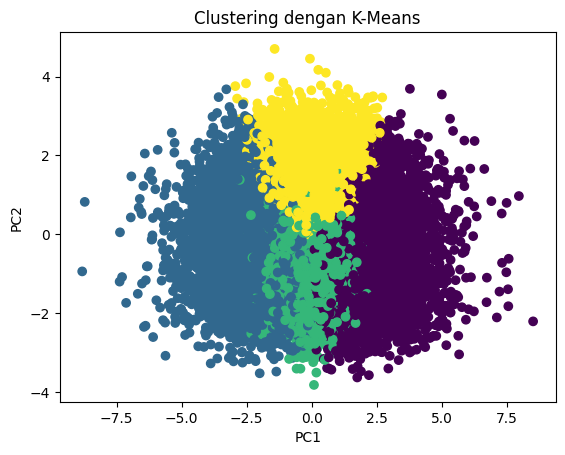

In [75]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Preprocessing: Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_train)

# Clustering dengan K-Means (misal 5 klaster)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

# Prediksi klaster
clusters = kmeans.predict(X_scaled)

# Visualisasi hasil klastering (misalnya 2D PCA untuk visualisasi)
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

# Plot hasil clustering
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering dengan K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [76]:
labels_train = kmeans.labels_
print(labels_train)
labels_train = kmeans.labels_
print(labels_train)


[2 3 3 ... 2 3 2]
[2 3 3 ... 2 3 2]


In [77]:
labels_train = kmeans.labels_
print(labels_train)
labels_train = kmeans.labels_
print(labels_train)


[2 3 3 ... 2 3 2]
[2 3 3 ... 2 3 2]


In [78]:
X_train['hasil_cluster'] = labels_train
print(X_train.head())

       isoelectric_point  nonpolar_ratio  sequence_length  enzyme_motif_count  \
14003           6.480805        0.400749              267                   0   
52603           7.706253        0.384615              182                   0   
5398            8.921474        0.391304              138                   0   
11723           8.724587        0.391791              268                   0   
6436            8.920700        0.418502              227                   0   

       hydrophobic_ratio  polarRation  has_phospho_site  has_glyco_site  \
14003           0.344569     0.340824                 1               1   
52603           0.340659     0.351648                 1               1   
5398            0.362319     0.369565                 1               1   
11723           0.347015     0.354478                 1               1   
6436            0.365639     0.352423                 1               1   

       signal_peptide_score  hasil_cluster  
14003            

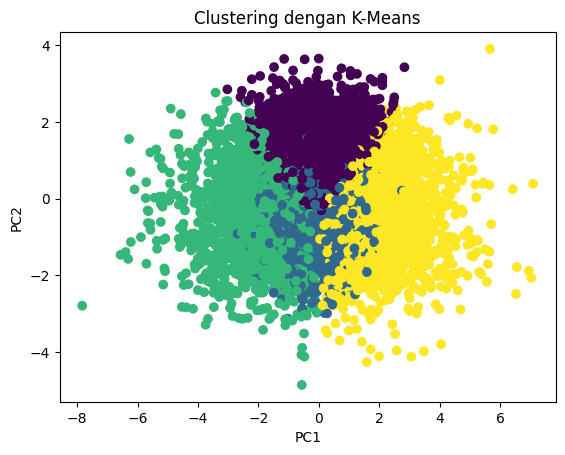

In [79]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Preprocessing: Scaling data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_test)

# Clustering dengan K-Means (misal 5 klaster)
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_scaled)

# Prediksi klaster
clusters = kmeans.predict(X_scaled)

# Visualisasi hasil klastering (misalnya 2D PCA untuk visualisasi)
from sklearn.decomposition import PCA
pca = PCA(n_components=8)
X_pca = pca.fit_transform(X_scaled)

# Plot hasil clustering
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters, cmap='viridis')
plt.title('Clustering dengan K-Means')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()


In [4]:
X_test

array([[ 1, 10, 18, ...,  0,  0,  0],
       [ 1,  6,  4, ...,  0,  0,  0],
       [17, 12, 20, ...,  0,  0,  0],
       ...,
       [16, 11, 16, ...,  0,  0,  0],
       [ 1, 16,  3, ...,  0,  0,  0],
       [ 9,  5,  6, ...,  0,  0,  0]])

In [80]:
labels_train = kmeans.labels_
print(labels_train)
labels_train = kmeans.labels_
print(labels_train)


[0 0 0 ... 3 2 2]
[0 0 0 ... 3 2 2]


In [82]:
X_test['hasil_cluster'] = labels_train
print(X_test.head())

       isoelectric_point  nonpolar_ratio  sequence_length  enzyme_motif_count  \
26249           6.847302        0.359712              139                   0   
55895           8.736514        0.395604              273                   1   
1609            8.730583        0.407692              130                   0   
44980           9.397057        0.388889               54                   0   
2421            7.737628        0.432749              171                   0   

       hydrophobic_ratio  polarRation  has_phospho_site  has_glyco_site  \
26249           0.323741     0.330935                 1               1   
55895           0.358974     0.344322                 1               1   
1609            0.361538     0.361538                 1               1   
44980           0.333333     0.444444                 1               1   
2421            0.391813     0.339181                 1               1   

       signal_peptide_score  hasil_cluster  
26249            

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 300, 64)           1344      
                                                                 
 conv1d_2 (Conv1D)           (None, 296, 64)           20544     
                                                                 
 conv1d_3 (Conv1D)           (None, 294, 128)          24704     
                                                                 
 conv1d_4 (Conv1D)           (None, 292, 256)          98560     
                                                                 
 global_max_pooling1d_2 (Glo  (None, 256)              0         
 balMaxPooling1D)                                                
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                      

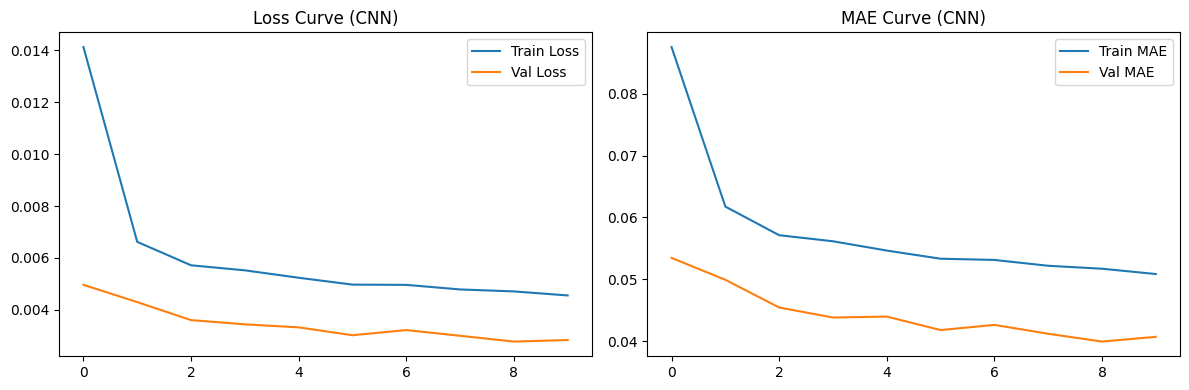

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def read_rename(path: str) -> pd.DataFrame:
    df = pd.read_csv(path)
    df = df.rename(columns={
        'ID_Proteína': 'protein_id',
        'Sequência': 'sequence',
        'Massa_Molecular': 'molecular_weight',
        'Ponto_Isoelétrico': 'isoelectric_point',
        'Hidrofobicidade': 'hydrophobicity',
        'Carga_Total': 'total_charge',
        'Proporção_Polar': 'polar_ratio',
        'Proporção_Apolar': 'nonpolar_ratio',
        'Comprimento_Sequência': 'sequence_length',
        'Classe': 'class'
    })
    return df

# 1. Load data
df = read_rename('proteinas_20000_enriquecido.csv')

# 2. Mapping karakter ke angka
all_chars = set("".join(df['sequence'].values))
char_to_index = {char: idx + 1 for idx, char in enumerate(sorted(all_chars))}
vocab_size = len(char_to_index) + 1

# 3. Encode sequence
encoded_sequences = [[char_to_index[char] for char in seq] for seq in df['sequence']]
max_length = max(len(seq) for seq in encoded_sequences)
X_all = pad_sequences(encoded_sequences, maxlen=max_length, padding='post')

# 4. Target variabel
y_all = df[['molecular_weight', 'isoelectric_point', 'hydrophobicity', 'total_charge', 'polar_ratio', 'nonpolar_ratio', 'sequence_length']].values

# 5. Split data
X_train, X_test, y_train, y_test = train_test_split(X_all, y_all, test_size=0.2, random_state=42)

# 6. Scaling target
scaler = MinMaxScaler()
y_train_scaled = scaler.fit_transform(y_train)
y_test_scaled = scaler.transform(y_test)

# 7. CNN model
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=64, input_length=max_length),
    
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    Conv1D(filters=128, kernel_size=3, activation='relu'),
    Conv1D(filters=256, kernel_size=3, activation='relu'),

    GlobalMaxPooling1D(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(7)  # output regresi
])


model.compile(optimizer='adam', loss='mse', metrics=['mae'])
model.summary()

# 8. Callback
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 9. Train model
history = model.fit(
    X_train, y_train_scaled,
    epochs=10,
    batch_size=32,
    validation_data=(X_test, y_test_scaled),
    callbacks=[early_stop],
    verbose=1
)

# 10. Predict
y_pred_scaled = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred_scaled)

# 11. Show predictions
print(pd.DataFrame(y_pred[:5], columns=['mw', 'pI', 'hydro', 'charge', 'polar', 'nonpolar', 'seq_len']))

# 12. Plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title("Loss Curve (CNN)")

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Train MAE')
plt.plot(history.history['val_mae'], label='Val MAE')
plt.legend()
plt.title("MAE Curve (CNN)")

plt.tight_layout()
plt.show()


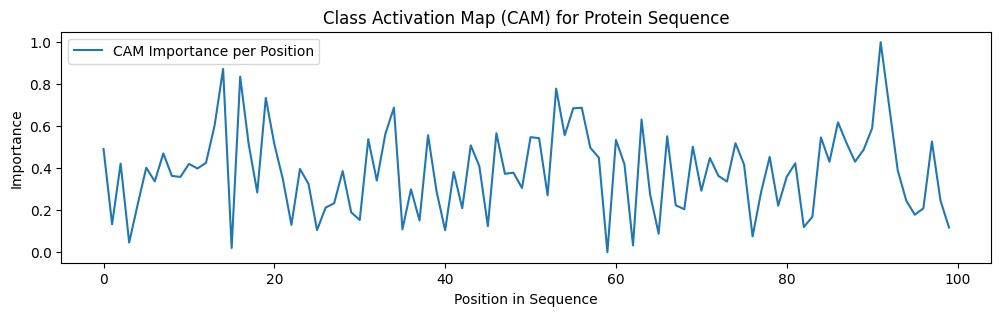

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Simulasi 1 urutan protein sebagai vektor embedding
# Misal: sequence_length=100, embedding_dim=21 (seperti one-hot amino acid)
sequence_length = 100
embedding_dim = 21

# Input [1, 21, 100] → [batch, channel, sequence]
x_input = torch.randn(1, embedding_dim, sequence_length)

# CNN Model dengan Global Average Pooling
class SimpleCAMModel(nn.Module):
    def __init__(self):
        super(SimpleCAMModel, self).__init__()
        self.conv = nn.Conv1d(embedding_dim, 32, kernel_size=5, padding=2)  # [B, 32, 100]
        self.relu = nn.ReLU()
        self.gap = nn.AdaptiveAvgPool1d(1)  # [B, 32, 1]
        self.fc = nn.Linear(32, 2)  # Binary classification: Enzim / Non-Enzim
        
    def forward(self, x):
        self.feature_maps = self.relu(self.conv(x))  # Save feature maps before pooling
        x = self.gap(self.feature_maps)  # [B, 32, 1]
        x = x.view(x.size(0), -1)  # Flatten
        output = self.fc(x)
        return output

# Instantiate model
model = SimpleCAMModel()

# Forward pass
output = model(x_input)
pred_class = torch.argmax(output)

# Get the weights of the fully connected layer
fc_weights = model.fc.weight.detach().numpy()  # Shape: [2, 32]
feature_maps = model.feature_maps.detach().numpy()[0]  # Shape: [32, 100]

# Compute CAM for predicted class
weights_for_class = fc_weights[pred_class]  # [32]
cam = np.zeros(sequence_length)

for i, w in enumerate(weights_for_class):
    cam += w * feature_maps[i]  # Weighted sum of each channel

# Normalize CAM for visualization
cam = (cam - cam.min()) / (cam.max() - cam.min())

# Plotting
plt.figure(figsize=(12, 3))
plt.plot(cam, label='CAM Importance per Position')
plt.title("Class Activation Map (CAM) for Protein Sequence")
plt.xlabel("Position in Sequence")
plt.ylabel("Importance")
plt.legend()
plt.show()


Epoch 1/30
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 433s 281ms/step - loss: 0.0267 - mae: 0.1162 - val_loss: 0.0021 - val_mae: 0.0328